# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: C:\Users\balda\mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 2, 42, 32, 284395)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 02:42:32,334 INFO: Initializing external client
2025-11-18 02:42:32,337 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 02:42:34,081 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 02:42:36,424 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1291412


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=2,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 02:42:42,653 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/481252 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/137084 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26343 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.2699818E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-22 00:00:00+00:00,3.65,0.7,9.199390,300.579132,bologna
1,2025-11-23 00:00:00+00:00,9.35,0.0,5.411986,86.186005,bologna
2,2025-11-20 00:00:00+00:00,8.85,0.0,8.942214,310.100830,bologna
3,2025-11-21 00:00:00+00:00,6.55,1.5,12.682018,304.592346,bologna
4,2025-11-19 00:00:00+00:00,9.65,0.0,8.225035,66.801392,bologna
5,2025-11-24 00:00:00+00:00,11.35,0.7,11.384199,108.435043,bologna


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [15]:
# Rename forecast columns to match the feature naming convention used during model training
batch_data = batch_data.rename(columns={
    'temperature_2m_mean': 'weather_temperature_2m_mean',
    'precipitation_sum': 'weather_precipitation_sum',
    'wind_speed_10m_max': 'weather_wind_speed_10m_max',
    'wind_direction_10m_dominant': 'weather_wind_direction_10m_dominant'
})

# Retrieve the most recent actual air quality data from the Feature Store to populate lagged features
aq_fg = fs.get_feature_group(name='air_quality', version=2)
history_df = aq_fg.read()
last_known_record = history_df.sort_values('date').iloc[-1]

# Populate lagged feature columns using the most recent historical observations
batch_data['pm25_lag_1'] = last_known_record['pm25']
batch_data['pm25_lag_2'] = last_known_record['pm25_lag_1']
batch_data['pm25_lag_3'] = last_known_record['pm25_lag_2']

# Select only numerical features for inference
input_data = batch_data.select_dtypes(include=['number'])

# Reorder input columns to strictly match the sequence expected by the trained XGBoost model
expected_order = retrieved_xgboost_model.get_booster().feature_names
input_data = input_data[expected_order]

# Execute prediction
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(input_data)

# Output results
batch_data.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.71s) 


,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
4,2025-11-19 00:00:00+00:00,9.65,0.0,8.225035,66.801392,bologna,4.0,4.18,12.88,10.715810,via-john-cage,italy,5
2,2025-11-20 00:00:00+00:00,8.85,0.0,8.942214,310.100830,bologna,4.0,4.18,12.88,18.483383,via-john-cage,italy,3
3,2025-11-21 00:00:00+00:00,6.55,1.5,12.682018,304.592346,bologna,4.0,4.18,12.88,14.304454,via-john-cage,italy,4
0,2025-11-22 00:00:00+00:00,3.65,0.7,9.199390,300.579132,bologna,4.0,4.18,12.88,15.162552,via-john-cage,italy,1
1,2025-11-23 00:00:00+00:00,9.35,0.0,5.411986,86.186005,bologna,4.0,4.18,12.88,21.747265,via-john-cage,italy,2


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype                  
---  ------                               --------------  -----                  
 0   date                                 6 non-null      datetime64[us, Etc/UTC]
 1   weather_temperature_2m_mean          6 non-null      float32                
 2   weather_precipitation_sum            6 non-null      float32                
 3   weather_wind_speed_10m_max           6 non-null      float32                
 4   weather_wind_direction_10m_dominant  6 non-null      float32                
 5   city                                 6 non-null      object                 
 6   pm25_lag_1                           6 non-null      float32                
 7   pm25_lag_2                           6 non-null      float32                
 8   pm25_lag_3                           6 non-null      float32              

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
4,2025-11-19 00:00:00+00:00,9.65,0.0,8.225035,66.801392,bologna,4.0,4.18,12.88,10.715810,via-john-cage,italy,5
2,2025-11-20 00:00:00+00:00,8.85,0.0,8.942214,310.100830,bologna,4.0,4.18,12.88,18.483383,via-john-cage,italy,3
3,2025-11-21 00:00:00+00:00,6.55,1.5,12.682018,304.592346,bologna,4.0,4.18,12.88,14.304454,via-john-cage,italy,4
0,2025-11-22 00:00:00+00:00,3.65,0.7,9.199390,300.579132,bologna,4.0,4.18,12.88,15.162552,via-john-cage,italy,1
1,2025-11-23 00:00:00+00:00,9.35,0.0,5.411986,86.186005,bologna,4.0,4.18,12.88,21.747265,via-john-cage,italy,2
5,2025-11-24 00:00:00+00:00,11.35,0.7,11.384199,108.435043,bologna,4.0,4.18,12.88,5.691942,via-john-cage,italy,6


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 4 to 5
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype                  
---  ------                               --------------  -----                  
 0   date                                 6 non-null      datetime64[us, Etc/UTC]
 1   weather_temperature_2m_mean          6 non-null      float32                
 2   weather_precipitation_sum            6 non-null      float32                
 3   weather_wind_speed_10m_max           6 non-null      float32                
 4   weather_wind_direction_10m_dominant  6 non-null      float32                
 5   city                                 6 non-null      object                 
 6   pm25_lag_1                           6 non-null      float32                
 7   pm25_lag_2                           6 non-null      float32                
 8   pm25_lag_3                           6 non-null      float32                
 9

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 02:42:55,096 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



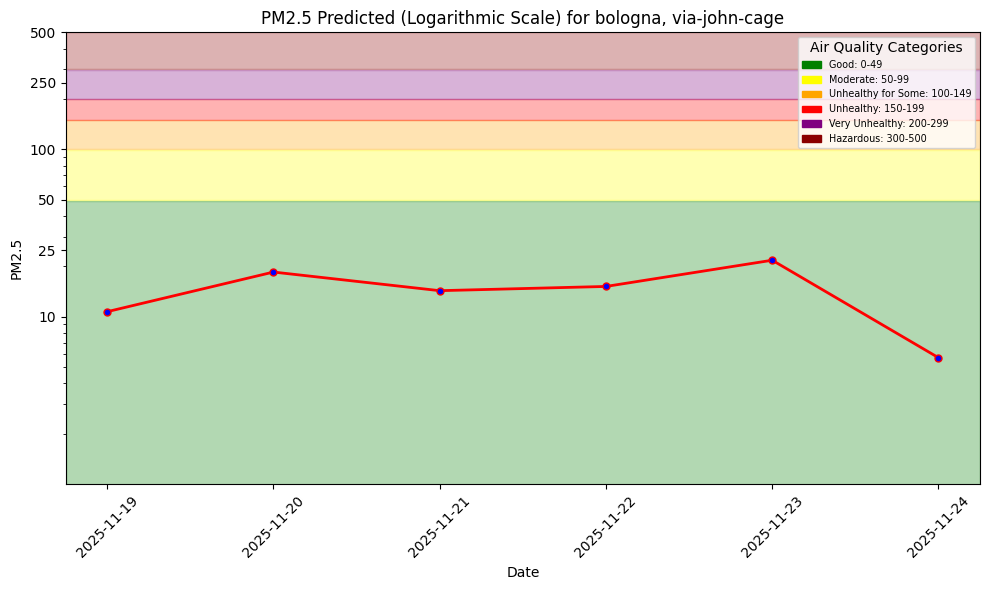

In [12]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [16]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [17]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1291412/fs/1280067/fg/1718924


Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1291412/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-18 02:47:19,551 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 02:47:22,782 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 02:48:58,644 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 02:48:58,818 INFO: Waiting for log aggregation to finish.
2025-11-18 02:49:14,481 INFO: Execution finished successfully.


(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [18]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.97s) 


,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-22 00:00:00+00:00,3.65,0.7,9.19939,300.579132,bologna,4.0,4.18,12.88,15.162552,via-john-cage,italy,1


In [19]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 


,date,pm25,country,city,street,url
0,2022-06-07 00:00:00+00:00,3.00,italy,bologna,via-john-cage,https://api.waqi.info/feed/A94354
1,2025-08-19 00:00:00+00:00,6.10,italy,bologna,via-john-cage,https://api.waqi.info/feed/A94354
2,2023-10-14 00:00:00+00:00,4.84,italy,bologna,via-john-cage,https://api.waqi.info/feed/A94354
3,2021-04-03 00:00:00+00:00,2.29,italy,bologna,via-john-cage,https://api.waqi.info/feed/A94354
4,2024-05-14 00:00:00+00:00,6.50,italy,bologna,via-john-cage,https://api.waqi.info/feed/A94354
...,...,...,...,...,...,...
1945,2021-04-13 00:00:00+00:00,0.93,italy,bologna,via-john-cage,https://api.waqi.info/feed/A94354
1946,2023-11-17 00:00:00+00:00,4.22,italy,bologna,via-john-cage,https://api.waqi.info/feed/A94354
1947,2020-07-28 00:00:00+00:00,2.65,italy,bologna,via-john-cage,https://api.waqi.info/feed/A94354
1948,2021-05-19 00:00:00+00:00,0.40,italy,bologna,via-john-cage,https://api.waqi.info/feed/A94354


In [26]:
# Verify if monitoring data is absent; if so, generate historical predictions dynamically for the hindcast
if len(hindcast_df) == 0:
    print("Monitoring Feature Group empty. Generating historical hindcast using Feature View training data...")

    # Retrieve the complete training dataset (features + labels) directly from the Feature View.
    # This ensures features (X) and targets (y) are perfectly aligned without manual merging.
    X_all, y_all = feature_view.get_training_data(1)
    
    # Concatenate features and labels into a single DataFrame and sort chronologically
    history_df = pd.concat([X_all, y_all], axis=1)
    history_df['date'] = pd.to_datetime(history_df['date'])
    history_df = history_df.sort_values('date')
    
    # Filter the dataset to retain only the most recent 14 days for visualization
    history_df = history_df.tail(14)
    
    # Select and reorder feature columns to strictly match the XGBoost model's expected input signature
    # This prevents schema mismatch errors during inference
    features_clean = history_df[retrieved_xgboost_model.get_booster().feature_names]
    
    # Generate PM2.5 predictions using the retrieved model
    history_df['predicted_pm25'] = retrieved_xgboost_model.predict(features_clean)
    
    # Construct the final hindcast DataFrame containing dates, actual values, and predictions
    hindcast_df = history_df[['date', 'pm25', 'predicted_pm25']]

print("Hindcast generation completed.")
hindcast_df.tail()

Hindcast generation completed.


,date,pm25,predicted_pm25
3,2025-11-08,18.48,37.170208
4,2025-11-09,14.45,21.144186
5,2025-11-10,12.88,12.165798
6,2025-11-11,4.18,17.592838
7,2025-11-18,4.00,5.235404


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

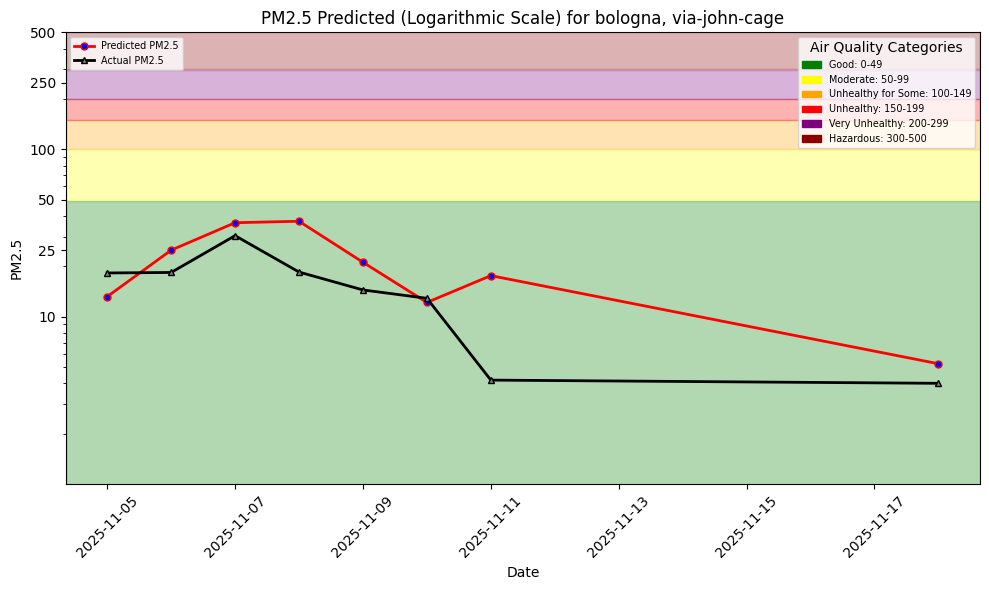

In [27]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [28]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading C:\Users\balda\mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | 0/47519 e…

Uploading C:\Users\balda\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|          | 0/59…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1291412/settings/fb/path/Resources/airquality


---